In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")
mixed_precision.set_global_policy("mixed_float16")

print("GPUs:", tf.config.list_physical_devices("GPU"))


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
BASE_PATH = "/content/drive/MyDrive/14935094/plantsegv3/plantsegv3"

df = pd.read_csv(os.path.join(BASE_PATH, "Metadatav2.csv"))

# Select top 6 diseases
top_classes = df["Disease"].value_counts().head(6).index.tolist()
df = df[df["Disease"].isin(top_classes)].copy()

class_map = {c:i for i,c in enumerate(top_classes)}
df["label_int"] = df["Disease"].map(class_map)

# Ensure mask ratio is float32
df["Mask ratio"] = df["Mask ratio"].astype("float32")


In [ ]:
def index_images(root):
    d = {}
    for r,_,f in os.walk(root):
        for fn in f:
            d[fn.lower()] = os.path.join(r, fn)
    return d

img_index = index_images(os.path.join(BASE_PATH, "images"))

df["filepath"] = df["Name"].str.lower().map(img_index)
df = df.dropna(subset=["filepath"])


In [ ]:
df_train = df[df["Split"]=="Training"].copy()
df_val   = df[df["Split"]=="Validation"].copy()


In [ ]:
IMG_SIZE = 192
BATCH = 32

def make_dataset(df, training=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (
            df["filepath"].values,
            (
                df["label_int"].values.astype("int32"),
                df["Mask ratio"].values.astype("float32")  # 🔥 mask ratio
            )
        )
    )

    def _map(p, y):
        label, severity = y
        img = tf.io.read_file(p)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        img = tf.cast(img, tf.float32) / 255.0
        return img, (label, severity)

    if training:
        ds = ds.shuffle(512)

    return (
        ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
          .cache()
          .batch(BATCH)
          .prefetch(tf.data.AUTOTUNE)
    )

train_ds = make_dataset(df_train, True)
val_ds   = make_dataset(df_val, False)


In [ ]:
NUM_CLASSES = len(class_map)

def build_model():
    inp = layers.Input((IMG_SIZE, IMG_SIZE, 3))

    x = layers.RandomFlip("horizontal")(inp)
    x = layers.RandomRotation(0.1)(x)

    base = DenseNet121(
        include_top=False,
        weights="imagenet",
        input_tensor=x
    )
    base.trainable = False   # stage-1 freeze

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    class_out = layers.Dense(
        NUM_CLASSES,
        activation="softmax",
        dtype="float32",
        name="class_output"
    )(x)

    severity_out = layers.Dense(
        1,
        activation="sigmoid",
        dtype="float32",
        name="severity_output"
    )(x)

    return models.Model(inp, [class_out, severity_out]), base

model, backbone = build_model()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def severity_aware_focal_loss(y_true, y_pred, severity,
                              gamma=2.0, alpha=0.25, sev_weight=2.0):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.float32)
    severity = tf.cast(severity, tf.float32)

    y_oh = tf.one_hot(y_true, tf.shape(y_pred)[-1])
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)

    pt = tf.reduce_sum(y_oh * y_pred, axis=-1)
    focal = alpha * tf.pow(1.0 - pt, gamma)
    ce = -tf.reduce_sum(y_oh * tf.math.log(y_pred), axis=-1)

    # 🔥 mask ratio weighting
    severity_factor = 1.0 + sev_weight * tf.squeeze(severity)

    loss = focal * ce * severity_factor
    return tf.reduce_mean(loss)


In [ ]:
class MultiTaskTrainer(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.cls_acc = tf.keras.metrics.SparseCategoricalAccuracy()
        self.sev_mae = tf.keras.metrics.MeanAbsoluteError()

    def train_step(self, data):
        x, (y_cls, y_sev) = data

        with tf.GradientTape() as tape:
            p_cls, p_sev = self.model(x, training=True)

            loss_cls = severity_aware_focal_loss(y_cls, p_cls, y_sev)
            loss_sev = tf.reduce_mean(
                tf.keras.losses.MAE(y_sev, p_sev)
            )

            loss = loss_cls + 0.5 * loss_sev

        grads = tape.gradient(loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        self.cls_acc.update_state(y_cls, p_cls)
        self.sev_mae.update_state(y_sev, p_sev)

        return {
            "loss": loss,
            "class_accuracy": self.cls_acc.result(),
            "severity_mae": self.sev_mae.result()
        }

    def test_step(self, data):
        x, (y_cls, y_sev) = data
        p_cls, p_sev = self.model(x, training=False)

        loss_cls = severity_aware_focal_loss(y_cls, p_cls, y_sev)
        loss_sev = tf.reduce_mean(tf.keras.losses.MAE(y_sev, p_sev))
        loss = loss_cls + 0.5 * loss_sev

        self.cls_acc.update_state(y_cls, p_cls)
        self.sev_mae.update_state(y_sev, p_sev)

        return {
            "loss": loss,
            "class_accuracy": self.cls_acc.result(),
            "severity_mae": self.sev_mae.result()
        }


In [ ]:
trainer = MultiTaskTrainer(model)
trainer.compile(optimizer=optimizers.Adam(1e-4))

trainer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150
)


Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step - class_accuracy: 0.2033 - loss: 0.7225 - severity_mae: 0.3447 - val_class_accuracy: 0.2312 - val_loss: 0.4196 - val_severity_mae: 0.4146
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - class_accuracy: 0.2344 - loss: 0.5893 - severity_mae: 0.2828 - val_class_accuracy: 0.3568 - val_loss: 0.3416 - val_severity_mae: 0.2905
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - class_accuracy: 0.2953 - loss: 0.4942 - severity_mae: 0.2195 - val_class_accuracy: 0.4774 - val_loss: 0.2787 - val_severity_mae: 0.2096
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - class_accuracy: 0.3464 - loss: 0.4072 - severity_mae: 0.1699 - val_class_accuracy: 0.5829 - val_loss: 0.2289 - val_severity_mae: 0.1681
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - class_accuracy: 0.4286 - loss: 0.3534 - severity_mae: 0.1391 - val_class_accuracy: 0.6583 - val_loss: 0.1853 - val_severity_mae: 0.1461
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/

In [ ]:
for layer in backbone.layers[-40:]:
    layer.trainable = True

trainer.compile(optimizer=optimizers.Adam(1e-5))

trainer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50

)


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 238ms/step - class_accuracy: 0.9142 - loss: 0.0795 - severity_mae: 0.0818 - val_class_accuracy: 0.8894 - val_loss: 0.0839 - val_severity_mae: 0.0909
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - class_accuracy: 0.9244 - loss: 0.0773 - severity_mae: 0.0808 - val_class_accuracy: 0.8894 - val_loss: 0.0770 - val_severity_mae: 0.0916
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - class_accuracy: 0.9103 - loss: 0.0809 - severity_mae: 0.0813 - val_class_accuracy: 0.8894 - val_loss: 0.0729 - val_severity_mae: 0.0923
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - class_accuracy: 0.9161 - loss: 0.0742 - severity_mae: 0.0774 - val_class_accuracy: 0.8894 - val_loss: 0.0704 - val_severity_mae: 0.0934
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - class_accuracy: 0.9160 - loss: 0.0756 - severity_mae: 0.0800 - val_class_accuracy: 0.8894 - val_loss: 0.0681 - val_severity_mae: 0.0942
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/st

In [ ]:
for layer in backbone.layers[-40:]:
    layer.trainable = True

trainer.compile(optimizer=optimizers.Adam(1e-5))

trainer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    initial_epoch=50
)


Epoch 51/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 243ms/step - class_accuracy: 0.9299 - loss: 0.0701 - severity_mae: 0.0763 - val_class_accuracy: 0.8894 - val_loss: 0.0742 - val_severity_mae: 0.0956
Epoch 52/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - class_accuracy: 0.9340 - loss: 0.0694 - severity_mae: 0.0779 - val_class_accuracy: 0.8894 - val_loss: 0.0745 - val_severity_mae: 0.0956
Epoch 53/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - class_accuracy: 0.9326 - loss: 0.0691 - severity_mae: 0.0772 - val_class_accuracy: 0.8894 - val_loss: 0.0746 - val_severity_mae: 0.0957
Epoch 54/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - class_accuracy: 0.9206 - loss: 0.0714 - severity_mae: 0.0826 - val_class_accuracy: 0.8894 - val_loss: 0.0750 - val_severity_mae: 0.0955
Epoch 55/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - class_accuracy: 0.9197 - loss: 0.0725 - severity_mae: 0.0783 - val_class_accuracy: 0.8894 - val_loss: 0.0751 - val_severity_mae: 0.0955
Epoch 56/100
41/41 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
metrics = trainer.evaluate(val_ds)
print(metrics)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - class_accuracy: 0.8842 - loss: 0.0925 - severity_mae: 0.0809
[<tf.Tensor: shape=(), dtype=float32, numpy=0.08454910665750504>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8894472122192383>, <tf.Tensor: shape=(), dtype=float32, numpy=0.09386005997657776>]


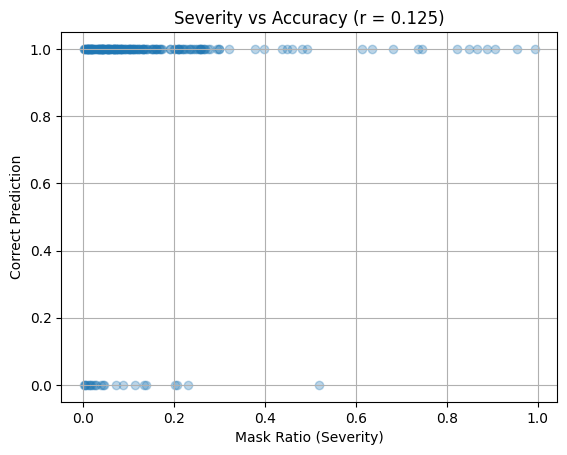

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

y_true, y_pred, y_sev = [], [], []

for x, (cls, sev) in val_ds:
    p_cls, _ = model(x, training=False)
    y_true.extend(cls.numpy())
    y_pred.extend(tf.argmax(p_cls, axis=1).numpy())
    y_sev.extend(sev.numpy().flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_sev  = np.array(y_sev)

correct = (y_true == y_pred).astype(int)

corr, _ = pearsonr(y_sev, correct)

plt.scatter(y_sev, correct, alpha=0.3)
plt.xlabel("Mask Ratio (Severity)")
plt.ylabel("Correct Prediction")
plt.title(f"Severity vs Accuracy (r = {corr:.3f})")
plt.grid()
plt.show()


severity_bin
Very Low     0.786885
Low          0.929577
Medium       0.934783
High         0.888889
Very High    1.000000
Name: correct, dtype: float64


/tmp/ipython-input-3709844701.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_acc = df_eval.groupby("severity_bin")["correct"].mean()


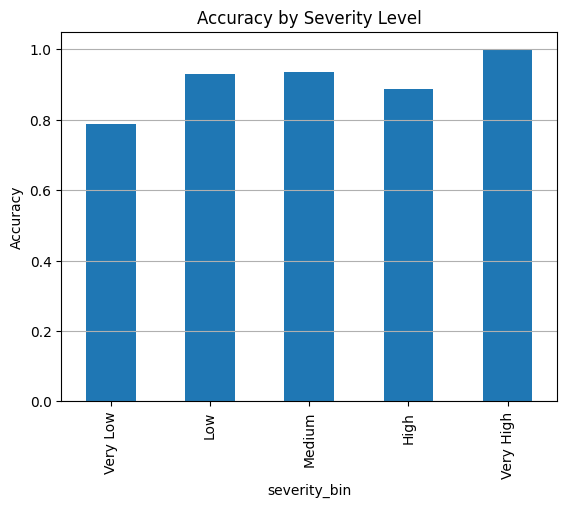

In [ ]:
import pandas as pd

df_eval = pd.DataFrame({
    "severity": y_sev,
    "correct": correct
})

bins = [0, 0.05, 0.15, 0.3, 0.6, 1.0]
labels = ["Very Low", "Low", "Medium", "High", "Very High"]

df_eval["severity_bin"] = pd.cut(df_eval["severity"], bins=bins, labels=labels)

bin_acc = df_eval.groupby("severity_bin")["correct"].mean()
print(bin_acc)

bin_acc.plot(kind="bar")
plt.ylabel("Accuracy")
plt.title("Accuracy by Severity Level")
plt.grid(axis="y")
plt.show()


In [ ]:
import numpy as np

y_true = []
y_pred = []

for x, (cls, sev) in val_ds:
    p_cls, _ = model(x, training=False)
    y_true.extend(cls.numpy())
    y_pred.extend(tf.argmax(p_cls, axis=1).numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Shapes:", y_true.shape, y_pred.shape)


Shapes: (199,) (199,)


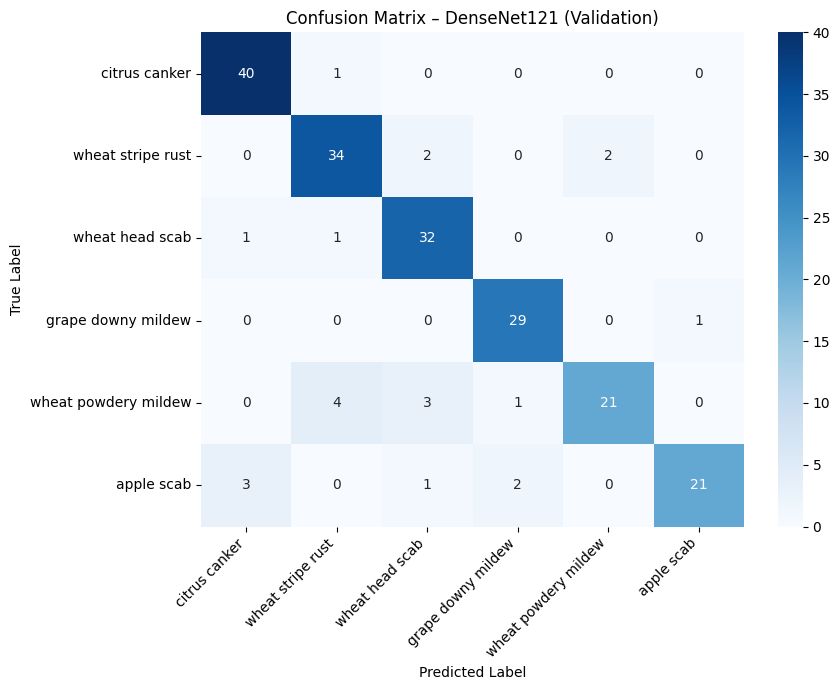

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Collect predictions
y_true, y_pred = [], []

for x, (cls, sev) in val_ds:
    p_cls, _ = model(x, training=False)
    y_true.extend(cls.numpy())
    y_pred.extend(tf.argmax(p_cls, axis=1).numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

class_names = list(class_map.keys())

plt.figure(figsize=(9,7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – DenseNet121 (Validation)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:   # or test_ds

    # labels = (class_labels, severity_labels)
    class_labels = labels[0]

    # Model prediction
    preds = model.predict(images, verbose=0)

    # Classification output
    class_probs = preds[0]                  # shape: (B, num_classes)
    class_preds = np.argmax(class_probs, axis=1)

    # True labels
    if len(class_labels.shape) > 1:          # one-hot case
        true_classes = np.argmax(class_labels.numpy(), axis=1)
    else:                                     # integer labels
        true_classes = class_labels.numpy()

    y_pred.extend(class_preds)
    y_true.extend(true_classes)


In [ ]:
# Example (change to your dataset)
class_names = list(class_map.keys())

print("Classes:", class_names)


Classes: ['citrus canker', 'wheat stripe rust', 'wheat head scab', 'grape downy mildew', 'wheat powdery mildew', 'apple scab']


In [ ]:
print(len(y_true), len(y_pred))
print("Sample y_true:", y_true[:10])
print("Sample y_pred:", y_pred[:10])


199 199
Sample y_true: [np.int32(5), np.int32(5), np.int32(5), np.int32(5), np.int32(5), np.int32(5), np.int32(5), np.int32(5), np.int32(5), np.int32(5)]
Sample y_pred: [np.int64(5), np.int64(3), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(2), np.int64(5), np.int64(0)]


In [ ]:
import numpy as np

per_class_acc = {}

y_true = np.array(y_true)
y_pred = np.array(y_pred)

for i, class_name in enumerate(class_names):
    idx = y_true == i               # samples of this class
    if np.sum(idx) == 0:
        per_class_acc[class_name] = 0
    else:
        per_class_acc[class_name] = np.mean(y_pred[idx] == y_true[idx])

print(per_class_acc)


{'citrus canker': np.float64(0.975609756097561), 'wheat stripe rust': np.float64(0.8947368421052632), 'wheat head scab': np.float64(0.9411764705882353), 'grape downy mildew': np.float64(0.9666666666666667), 'wheat powdery mildew': np.float64(0.7241379310344828), 'apple scab': np.float64(0.7777777777777778)}


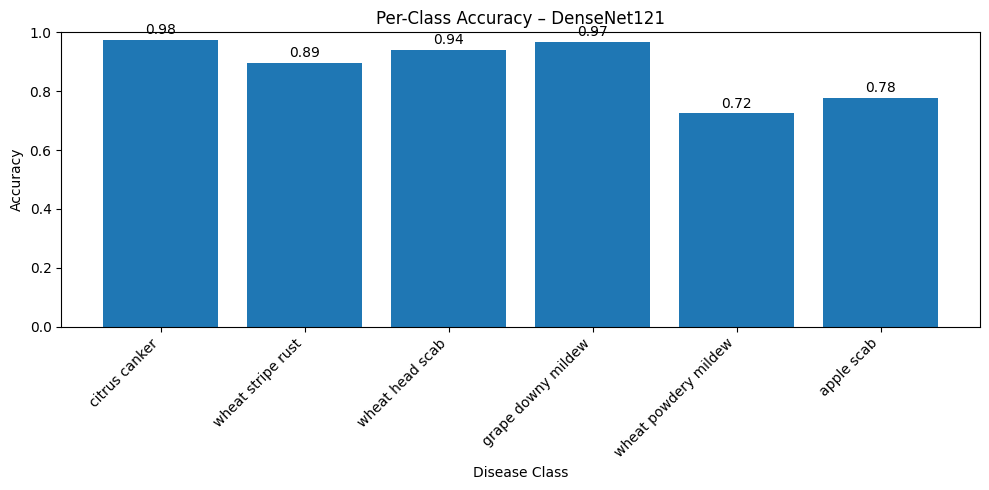

In [ ]:
import matplotlib.pyplot as plt

classes = list(per_class_acc.keys())
accuracies = list(per_class_acc.values())

plt.figure(figsize=(10,5))
bars = plt.bar(classes, accuracies)

plt.ylabel("Accuracy")
plt.xlabel("Disease Class")
plt.title("Per-Class Accuracy – DenseNet121")
plt.ylim(0, 1)

plt.xticks(rotation=45, ha="right")

# Value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + 0.01,
        f"{yval:.2f}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


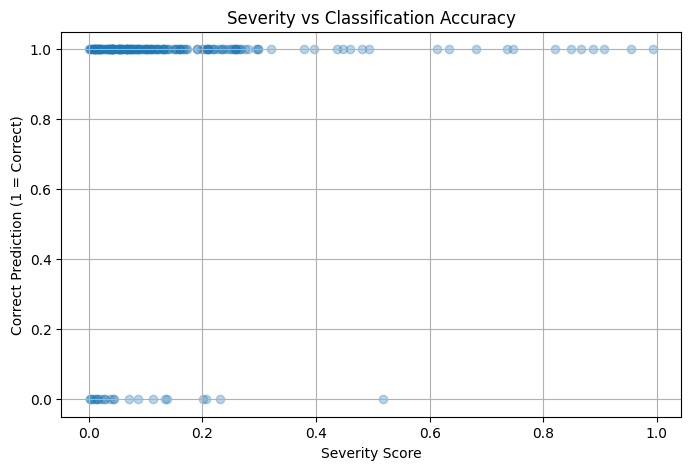

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

severity_vals = []
correct_flags = []

for images, labels in val_ds:
    class_labels, severity_labels = labels

    preds = model.predict(images, verbose=0)
    class_preds = np.argmax(preds[0], axis=1)

    true_classes = class_labels.numpy()
    severity = severity_labels.numpy().squeeze()

    correct = (class_preds == true_classes).astype(int)

    severity_vals.extend(severity)
    correct_flags.extend(correct)

severity_vals = np.array(severity_vals)
correct_flags = np.array(correct_flags)

plt.figure(figsize=(8,5))
plt.scatter(severity_vals, correct_flags, alpha=0.3)
plt.xlabel("Severity Score")
plt.ylabel("Correct Prediction (1 = Correct)")
plt.title("Severity vs Classification Accuracy")
plt.grid(True)
plt.show()


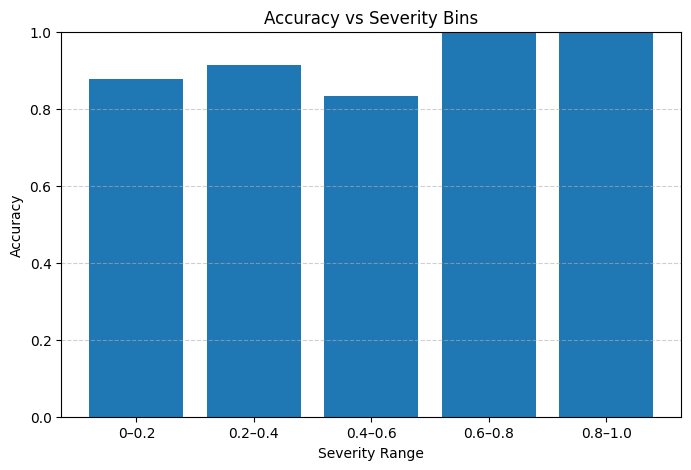

In [ ]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_acc = []

for i in range(len(bins)-1):
    mask = (severity_vals >= bins[i]) & (severity_vals < bins[i+1])
    if np.sum(mask) > 0:
        acc = np.mean(correct_flags[mask])
    else:
        acc = 0
    bin_acc.append(acc)

bin_labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins)-1)]

plt.figure(figsize=(8,5))
plt.bar(bin_labels, bin_acc)
plt.xlabel("Severity Range")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Severity Bins")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [ ]:
def grad_cam(model, img_tensor, class_index, layer_name="conv5_block16_2_conv"):
    # Create grad model
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[
            model.get_layer(layer_name).output,
            model.output[0]  # class output ONLY
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, class_index]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight conv feature maps
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # ReLU
    heatmap = tf.maximum(heatmap, 0)

    # Normalize safely
    max_val = tf.reduce_max(heatmap)
    heatmap = tf.cond(
        max_val > 0,
        lambda: heatmap / max_val,
        lambda: heatmap
    )

    return heatmap.numpy()


In [ ]:
def show_gradcam(img, heatmap):
    img = img[0].numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    heatmap = cv2.resize(
        heatmap,
        (img.shape[1], img.shape[0]),
        interpolation=cv2.INTER_LINEAR
    )

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed = heatmap * 0.4 + img * 255
    superimposed = superimposed.astype(np.uint8)

    plt.figure(figsize=(6,6))
    plt.imshow(superimposed)
    plt.axis("off")
    plt.title("Grad-CAM – DenseNet121")
    plt.show()


In [ ]:
def grad_cam(model, img_tensor, class_index, layer_name="conv5_block16_2_conv"):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[
            model.get_layer(layer_name).output,
            model.output[0]   # classification output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_tensor)
        loss = preds[:, class_index]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)

    # SAFE normalization
    max_val = tf.reduce_max(heatmap)
    heatmap = tf.where(
        max_val > 0,
        heatmap / max_val,
        tf.zeros_like(heatmap)
    )

    heatmap = tf.squeeze(heatmap)        # ✅ force 2D
    heatmap = heatmap.numpy().astype(np.float32)

    return heatmap


In [ ]:
def show_gradcam(img, heatmap):
    img = img[0].numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    # 🔥 HARD SAFETY CHECK
    if heatmap is None or heatmap.ndim != 2:
        raise ValueError(f"Invalid heatmap shape: {None if heatmap is None else heatmap.shape}")

    heatmap = cv2.resize(
        heatmap,
        (img.shape[1], img.shape[0]),
        interpolation=cv2.INTER_LINEAR
    )

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed = cv2.addWeighted(
        heatmap, 0.4,
        (img * 255).astype(np.uint8), 0.6,
        0
    )

    plt.figure(figsize=(6,6))
    plt.imshow(superimposed)
    plt.axis("off")
    plt.title("Grad-CAM – DenseNet121")
    plt.show()


Heatmap shape: (6, 6)


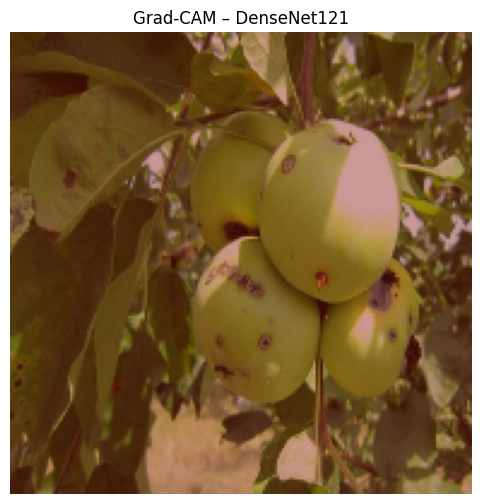

In [ ]:
for images, (labels, severities) in val_ds.take(1):
    preds_cls, _ = model(images, training=False)
    class_id = tf.argmax(preds_cls[0]).numpy()

    heatmap = grad_cam(model, images[:1], class_id)
    print("Heatmap shape:", heatmap.shape)  # should be (H, W)

    show_gradcam(images[:1], heatmap)


In [ ]:
history = {
    "loss": [],
    "val_loss": []
}

EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_logs = trainer.fit(
        train_ds,
        validation_data=val_ds,
        epochs=1,
        verbose=1
    )

    history["loss"].append(train_logs.history["loss"][0])
    history["val_loss"].append(train_logs.history["val_loss"][0])



Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - class_accuracy: 0.9364 - loss: 0.0640 - severity_mae: 0.0759 - val_class_accuracy: 0.8894 - val_loss: 0.0844 - val_severity_mae: 0.0937

Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - class_accuracy: 0.9288 - loss: 0.0648 - severity_mae: 0.0754 - val_class_accuracy: 0.8894 - val_loss: 0.0846 - val_severity_mae: 0.0935

Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - class_accuracy: 0.9331 - loss: 0.0625 - severity_mae: 0.0743 - val_class_accuracy: 0.8894 - val_loss: 0.0848 - val_severity_mae: 0.0936

Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - class_accuracy: 0.9305 - loss: 0.0658 - severity_mae: 0.0804 - val_class_accuracy: 0.8894 - val_loss: 0.0844 - val_severity_mae: 0.0936

Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - class_accuracy: 0.9541 - loss: 0.0656 - severity_mae: 0.0801 - val_class_accuracy: 0.8894 - val_loss: 0.0841 - val_severity_mae: 0.0938

Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 159

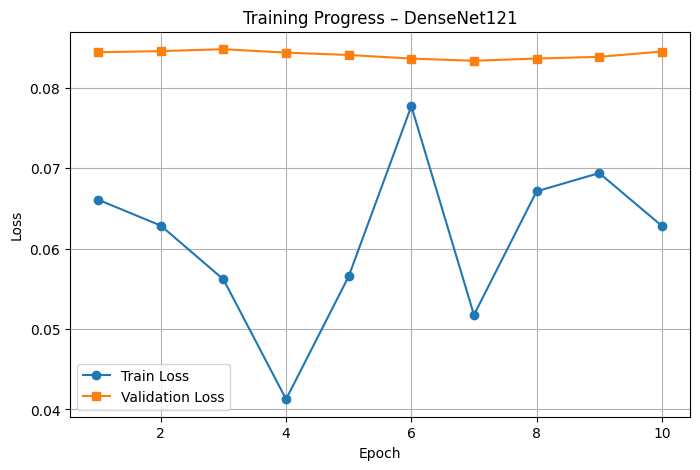

In [ ]:
import matplotlib.pyplot as plt

train_loss = history["loss"]
val_loss   = history["val_loss"]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, marker="o", label="Train Loss")
plt.plot(epochs, val_loss, marker="s", label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Progress – DenseNet121")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

y_true_sev = []
y_pred_sev = []

for images, (labels, severities) in val_ds:
    # Model prediction
    _, pred_sev = model(images, training=False)

    # Flatten tensors
    true_sev = severities.numpy().reshape(-1)
    pred_sev = pred_sev.numpy().reshape(-1)

    y_true_sev.extend(true_sev)
    y_pred_sev.extend(pred_sev)


In [ ]:
def severity_to_class(sev):
    if sev < 0.33:
        return 0  # Mild
    elif sev < 0.66:
        return 1  # Moderate
    else:
        return 2  # Severe

y_true_sev_cls = np.array([severity_to_class(s) for s in y_true_sev])
y_pred_sev_cls = np.array([severity_to_class(s) for s in y_pred_sev])


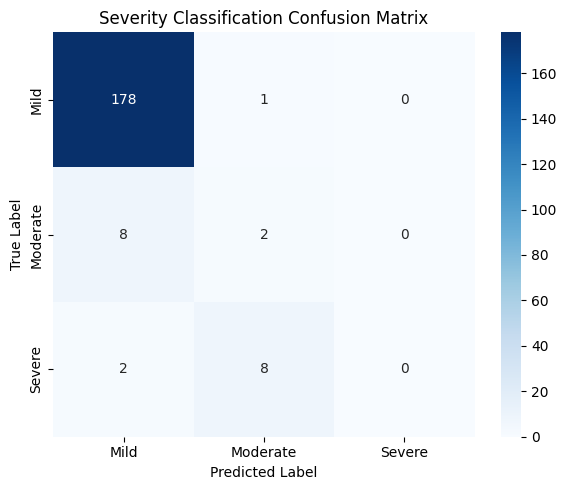

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

severity_labels = ["Mild", "Moderate", "Severe"]

cm = confusion_matrix(y_true_sev_cls, y_pred_sev_cls)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=severity_labels,
    yticklabels=severity_labels
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Severity Classification Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_sample(img, gt_mask, pred_mask, true_sev, pred_sev):
    plt.figure(figsize=(14,4))

    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.text(0.1, 0.6, f"True: {true_sev}", fontsize=12)
    plt.text(0.1, 0.4, f"Pred: {pred_sev}", fontsize=12)
    plt.title("Severity")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np

sample_images = []
sample_true_sev = []
sample_pred_sev = []

for images, (labels, severities) in val_ds:
    preds_cls, preds_sev = model(images, training=False)

    for i in range(images.shape[0]):
        sample_images.append(images[i].numpy())
        sample_true_sev.append(severities[i].numpy())
        sample_pred_sev.append(preds_sev[i].numpy())

    if len(sample_images) >= 3:
        break


In [ ]:
def severity_to_class(sev):
    if sev < 0.33:
        return 0
    elif sev < 0.66:
        return 1
    else:
        return 2

y_true_sev_cls = [severity_to_class(s) for s in sample_true_sev]
y_pred_sev_cls = [severity_to_class(s) for s in sample_pred_sev]


In [ ]:
import matplotlib.pyplot as plt

def visualize_sample(img, true_sev, pred_sev):
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"GT: {true_sev} | Pred: {pred_sev}")
    plt.show()


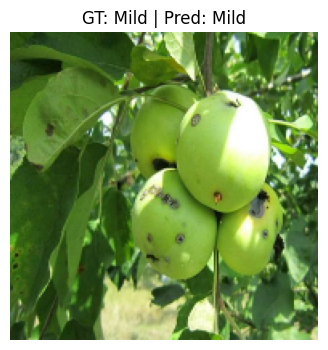

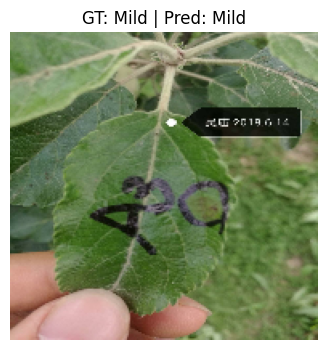

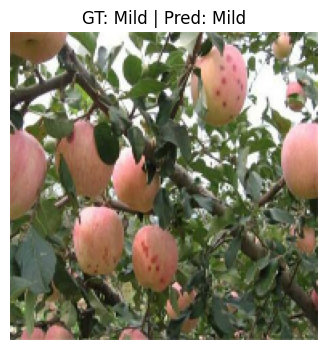

In [ ]:
severity_names = ["Mild", "Moderate", "Severe"]

for i in range(3):
    img = sample_images[i]
    true_sev = severity_names[y_true_sev_cls[i]]
    pred_sev = severity_names[y_pred_sev_cls[i]]

    visualize_sample(img, true_sev, pred_sev)
